#### AI Travel Agent & Expense Planner
##### Purpose: Trip planning for any city worldwide with Realtime data.

In [1]:

# LangChain Core Components
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain.chains import LLMChain

# Pydantic Data Modeling & Validation
import operator
from typing import Annotated, TypedDict, Sequence, List
from pydantic import BaseModel, Field

# LangGraph - State Management & Flow Control
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

# LangChain Community Tools for real-time web scrapping
from langchain_community.tools import tool
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.alpha_vantage import AlphaVantageAPIWrapper  

# LLM 
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq


##### Custom Typed State for LangGraph Memory

In [2]:
class MessageState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]
    step:int
    origin: str
    destination: str
    days: float
    budget: float

##### Structured PydanticOutput Schema for Travel Information

In [3]:


class Format(BaseModel):
    attractions:List[str]=Field(description="list of top 5 attractions at given location")
    restaurants:List[str]=Field(description="list of top 5 restaurants at given location")
    activities:List[str]=Field(description="list of top 5 activities to do, at given location")
    transportation:List[str]=Field(description="list of ways to transport from place of origin to given location")
    
output_parser=PydanticOutputParser(pydantic_object=Format)

In [3]:

llm=ChatGroq(model="llama-3.1-8b-instant")

##### Defining custom Tools 

In [5]:
@tool
def get_attarction_activites(Location:str,origin:str)->str:

    """This tool provides list of top 5 attractions, list of top 5 resturants with multi-cusines, list of top 5 activities to do and ways of transporation in given location 
    
    Args:
        Location (str): Trip Destination location
        origin (str): Place of origin for trip
        

    Returns:
        str: Deatils of attrcation of given location
        
        """
    
    
    prompt=PromptTemplate.from_template("""You are a helpful assistant that provides the following details about a destination:
                                            - Top 5 tourist attractions
                                            - Top 5 multi-cuisine restaurants
                                            - Top 5 activities to do
                                            - Ways of transportation from the place of origin to the destination

                                            Place of origin: {origin}
                                            Destination: {Location}

                                            Respond ONLY in the following JSON format:
                                            {format_instructions}
                                            """)
    
    chain= prompt| llm | output_parser
    res= chain.invoke({"Location":Location,"origin":origin,"format_instructions":output_parser.get_format_instructions()})
    print("res",res)

    
    
    return res

In [6]:
get_attarction_activites.invoke({"Location":"london","origin":"india"})



res attractions=['The British Museum', 'The National Gallery', 'The Tower of London', 'Buckingham Palace', 'The London Eye'] restaurants=['Dishoom', 'Padella', 'Honey & Co', 'The Delaunay', 'Brick Lane Curry House'] activities=['Take a West End musical', 'Explore the Camden Market', 'Visit a Premier League football match', 'Take a Thames River cruise', 'Walk in Hyde Park'] transportation=['Flights from major Indian cities to London Heathrow Airport', 'Flights from Mumbai to London Gatwick Airport', 'Trains from Paris to London with changes at Lille or Brussels', 'Bus journeys from European cities with companies like FlixBus', 'Cruise ships from Southampton to various destinations in Europe']


Format(attractions=['The British Museum', 'The National Gallery', 'The Tower of London', 'Buckingham Palace', 'The London Eye'], restaurants=['Dishoom', 'Padella', 'Honey & Co', 'The Delaunay', 'Brick Lane Curry House'], activities=['Take a West End musical', 'Explore the Camden Market', 'Visit a Premier League football match', 'Take a Thames River cruise', 'Walk in Hyde Park'], transportation=['Flights from major Indian cities to London Heathrow Airport', 'Flights from Mumbai to London Gatwick Airport', 'Trains from Paris to London with changes at Lille or Brussels', 'Bus journeys from European cities with companies like FlixBus', 'Cruise ships from Southampton to various destinations in Europe'])

#### Using `PyOWM` to fetch weather information of given Location

In [7]:
import os
import pyowm
from dotenv import load_dotenv

from warnings import filterwarnings
filterwarnings("ignore")

load_dotenv()

c:\Users\divya\Documents\GitHub\Agentic\myvenv\Lib\site-packages\pyowm\commons\cityidregistry.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


True

##### Used `OpenWeatherAPI` to fetch Real-time current and forecasting weather details of Destination Location

In [8]:
@tool
def get_weather_detail(Location:str)->str:
    
    """This tool provides current and forecasting weather for given location
    
    Args:
        Location (str): Trip Destination location
  
    
    Returns:
        str: Deatils of real-time current weather and forecasting of 15hrs ahead for given location
        
        """

    owm = pyowm.OWM(os.getenv("openweatherkey_one"))
    weather_mgr = owm.weather_manager()


    # Current weather
    observation = weather_mgr.weather_at_place(Location)
    weather_now = observation.weather
    current = {
        "temperature_celsius": weather_now.temperature("celsius")["temp"],
        "humidity": weather_now.humidity,
        "wind_speed_mps": weather_now.wind()["speed"],
        "status": weather_now.detailed_status
    }

    # Forecast (next 5 x 3h intervals)
    forecast = weather_mgr.forecast_at_place(Location, '3h')
    forecast_data = []
    for weather in forecast.forecast.weathers[:5]:  # limit to first 5 intervals
        entry = {
            "time": str(weather.reference_time('iso')),
            "temperature_celsius": weather.temperature("celsius")["temp"],
            "humidity": weather.humidity,
            "wind_speed_mps": weather.wind()["speed"],
            "status": weather.detailed_status
        }
        forecast_data.append(entry)

    result = {
        "location": Location,
        "current_weather": current,
        "forecast_next_15h": forecast_data
    }
    

    
    return str(result)
        
    

In [9]:
get_weather_detail.invoke({"Location":"London"})

"{'location': 'London', 'current_weather': {'temperature_celsius': 19.82, 'humidity': 73, 'wind_speed_mps': 2.57, 'status': 'few clouds'}, 'forecast_next_15h': [{'time': '2025-06-19 00:00:00+00:00', 'temperature_celsius': 19.77, 'humidity': 73, 'wind_speed_mps': 0.26, 'status': 'few clouds'}, {'time': '2025-06-19 03:00:00+00:00', 'temperature_celsius': 19.0, 'humidity': 72, 'wind_speed_mps': 0.14, 'status': 'few clouds'}, {'time': '2025-06-19 06:00:00+00:00', 'temperature_celsius': 19.54, 'humidity': 67, 'wind_speed_mps': 0.2, 'status': 'clear sky'}, {'time': '2025-06-19 09:00:00+00:00', 'temperature_celsius': 25.65, 'humidity': 46, 'wind_speed_mps': 0.71, 'status': 'clear sky'}, {'time': '2025-06-19 12:00:00+00:00', 'temperature_celsius': 28.94, 'humidity': 33, 'wind_speed_mps': 1.04, 'status': 'clear sky'}]}"

#### Used `TavilySearchAPI` for web scrapping of real-time Hotel and pricing Data

In [10]:
search_llm=ChatGroq(model="llama-3.1-8b-instant")
Tavily_search=TavilySearchResults()

In [11]:
@tool
def search_hotels(Location:str,budget:float,days:float)->str:
    
    """This tool searches for hotels and its prices in given location
    
    Args:
        Location (str): Trip Destination location
        budget  (foat): Total budget of trip
        days   (float): Duration of trip

    Returns:
        str: Deatils of real-time Hotels along with price-per night within budget for given location
    """


    search_llm=ChatGroq(model="llama-3.1-8b-instant")
    price_day=budget/(days+5)
    search_llm=ChatGroq(model="llama-3.1-8b-instant")
    hotels=search_llm.invoke(f"No description required, Just give list of Hotel names in {Location} with price per day {price_day}")
    print(hotels.content)
    Hotel_name=input("Enter a Hotel name that you would like to check cost estimation")
    
    return Hotel_name   


In [12]:
search_hotels({"Location":"London","budget":2850,"days":5})

Please note that prices may vary based on the time of year, availability, and other factors. Here's a list of hotels in London with prices around £285 per day (approximately $365 USD):

1. **Premier Inn London City (Tower Hill)** - £249 - £349 per night
2. **Ibis London Earl's Court** - £239 - £329 per night
3. **Holiday Inn London Kensington Forum** - £269 - £369 per night
4. **Novotel London City East** - £249 - £349 per night
5. **Park Plaza London Riverbank** - £259 - £359 per night
6. **Premier Inn London Euston** - £249 - £349 per night
7. **Hilton London Kensington** - £289 - £399 per night
8. **Ibis London Greenwich** - £239 - £329 per night
9. **Travelodge London Central Tower Bridge** - £239 - £329 per night
10. **Marriott London County Hall** - £299 - £409 per night
11. **DoubleTree by Hilton London - Westminster** - £289 - £399 per night
12. **Novotel London City South** - £249 - £349 per night
13. **Crowne Plaza London - The City** - £299 - £409 per night
14. **Jurys Inn L

'Jurys Inn London Kensington'

In [13]:
@tool
def get_hotel_price(Hotel_name:str,Location:str,budget:float,days:float)->str:

        """ This tool provides price per night for a given Hotel (as per budget) 
            and makes remaining budget estimation

        Args:
                Hotel_name (str): User-selected Hotel name
                Location   (str): Trip Destination location
                budget    (foat): Total budget of trip
                days     (float): Duration of trip

        Returns:
                str: Gives least price per night for user selected Hotel and 
                     site details along with budget estimation
        """
        
        res=Tavily_search.invoke(f"Provide price per night of {Hotel_name} in {Location}")
        print(res)
        
         # Convert list of dicts to plain text (context)
        context_text = "\n\n".join(
                f"Title: {r['title']}\nURL: {r['url']}\nContent: {r['content']}" for r in res 
        )

        budget_hotel = budget / (days + 5)

        print(context_text)

        
        prompt = f"""
        You are provided with hotel search results.

        Context:
        {context_text}

        Take lowest per-night price of the hotel based on the above content.
        Compare it with the allowed per-night budget: ${budget_hotel:.2f}.

        Then calculate total cost for {days} nights.
        Also calculate how much budget will remain after booking from total budget: ${budget:.2f}

        Return the answer in 2-3 lines, human-readable format.
        """

        result = search_llm.invoke(prompt)

        return result


#### Used `AlphaVantageAPIWrapper` for Real-time currency conversion to Destination 

In [14]:
def travel_Planning(state:MessageState):

    # Taking user-input regarding trip

    origin=input("Enter the place of origin for the journey").lower()
    location=input("Enter the city name for which you want travel plan and details").lower()
    Days=input("Enter no.of days for the trip")
    Days=float(Days)
    budget=input("Enter max budget in origin country currecy, for entire trip")
    budget=float(budget)

    print("Please wait...., while our AI travel agent is planning Iternary according to your details.....")
   
    state["origin"] = origin
    state["destination"] = location
    state["days"] = Days
    state["budget"] = budget


    SYSTEM_PROMPT = SystemMessage(
    content=f"""You are a helpful assistant tasked with currency conversion from Origin: {origin} to Destination: {location}, just provide currency codes nothing else
    Return each code on a separate line like this:\n\nINR\nGBP """)

    res=search_llm.invoke([SYSTEM_PROMPT]+ ["Return only the currency codes (e.g., INR, GBP), each on a separate line, of Origin and Destination"])
    print(res)
    origin_currency, destination_currency = res.content.split('\n')

    


    """ Currency conversion for planning budget according to Destination
    Used AlphaVantageAPIWrapper to get real-time currency exchange rates."""

    os.environ["ALPHAVANTAGE_API_KEY"] = os.getenv("ALPHAVANTAGE_API_KEY")
    alpha_vantage = AlphaVantageAPIWrapper()
    er=alpha_vantage._get_exchange_rate(origin_currency, destination_currency)
    print(er)
    er=alpha_vantage._get_exchange_rate(origin_currency, destination_currency)['Realtime Currency Exchange Rate']['5. Exchange Rate']
    er=float(er)
    state["budget"]=float(budget * er)
    state["step"]=1

    return state

In [15]:
myTools=[get_attarction_activites,get_weather_detail,search_hotels,get_hotel_price]

In [16]:

agent=ChatOpenAI(model="o4-mini")
React_agent=agent.bind_tools(myTools)

In [17]:
def agent_planning(state:MessageState):
    
    current_step=state["step"]
    origin = state["origin"]
    destination = state["destination"]
    days = state["days"]
    budget = state["budget"]
    step_name={
        0:"Currency conversion",
        1:"Search for Attractions and Activities",
        2:"Search for weather and forecasting",
        3:"Search for Hotels in given location",
        4:"Search price of given Hotel received from search_hotels",
        5:"END the process"
    }[current_step]

    if len(state["messages"])==0:
        context=HumanMessage(content="Start planning.")
    else:
        context=state["messages"][-1]

    template = """You are a helpful Travel planning assistant with binded tools, planning trip from {origin} to given Destination {destination}, for {days} days with total budget of {budget}.
                    Only take actions based on current step: "{current_step}".
                    Now perform step {current_step}: {step_name}.
                    Context: {context}"""

    prompt = PromptTemplate.from_template(template)

    
    chain = prompt | React_agent

    inputs = {
        "origin": origin,
        "destination": destination,
        "days": days,
        "budget": budget,
        "current_step": current_step,
        "step_name": step_name,
        "context": context,
    }
    res = chain.invoke(inputs)

    if res.tool_calls:
        state["step"]+=1
        
    return {"messages":[res],"step":state["step"]}

#### Setting up Agent workflow via langgraph

In [18]:
# workflow set up with stateGraph

workflow1=StateGraph(MessageState)
workflow1.add_node("start_planning",travel_Planning)
workflow1.add_node("Agent_Planning",agent_planning)

# adding tools as nodes
myTools=[get_attarction_activites,get_weather_detail,search_hotels,get_hotel_price]
tools=ToolNode(myTools)
workflow1.add_node("tools",tools)

workflow1.add_edge(START,"start_planning")
workflow1.add_edge("start_planning","Agent_Planning")

# Conditional edge for routing between tools
workflow1.add_conditional_edges("Agent_Planning",tools_condition)
workflow1.add_edge("tools","Agent_Planning")

react_agent=workflow1.compile()

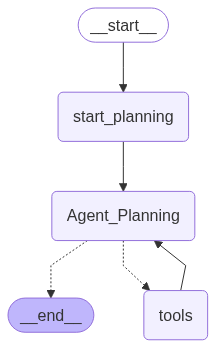

In [19]:
from IPython.display import Image, display
display(Image(react_agent.get_graph().draw_mermaid_png()))

In [ ]:
for output in react_agent.stream({"messages":[]}):
    for key,value in output.items():
        print(f"\n\t Below is the output from {key}")
        print("---------------------------------------------------------------------------------------------\n")
        print(value)
        print("\n\n\n")